In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss)
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    # original_loss = focal_loss(student_outputs[:,0,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0520/weights_KD_segformer_0520_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0409(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}

# Student Model: Segformer 0409
model_name = "nvidia/mit-b0"
num_classes = 2
model_segformer = MySegFormer_0409(num_classes)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        teacher_ratio = 0.6
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should pro

FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.3166

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 607ms/step - loss: 0.2559
Average validation loss: 0.6951875686645508
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 625ms/step - loss: 0.2559 - val_loss: 0.6952
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_5.pth'.
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 817ms/step - loss: 0.2036 - val_loss: 0.6952
Average validation loss: 0.5184075832366943
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 839ms/step - loss: 0.2036 - val_loss: 0.6068
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_5.pth'.
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 837ms/step - loss: 0.1665 - val_loss: 0.6068
Average validation loss: 0.45621341466903687
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 849ms/step - loss: 0.1665 - val_loss: 0.5566
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_se

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 894ms/step - loss: 0.0270
Average validation loss: 0.7949492037296295
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 908ms/step - loss: 0.0270 - val_loss: 0.7949
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_10.pth'.
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 856ms/step - loss: 0.0250 - val_loss: 0.7949
Average validation loss: 0.2289920449256897
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 870ms/step - loss: 0.0250 - val_loss: 0.5120
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_10.pth'.
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 843ms/step - loss: 0.0238 - val_loss: 0.5120
Average validation loss: 0.2192205935716629
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 857ms/step - loss: 0.0238 - val_loss: 0.4144
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 812ms/step - loss: 0.0205
Average validation loss: 0.28948042045036954
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 829ms/step - loss: 0.0205 - val_loss: 0.2895
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_15.pth'.
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 825ms/step - loss: 0.0174 - val_loss: 0.2895
Average validation loss: 0.24796729162335396
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 841ms/step - loss: 0.0174 - val_loss: 0.2687
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_15.pth'.
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 841ms/step - loss: 0.0163 - val_loss: 0.2687
Average validation loss: 0.07448323257267475
12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 851ms/step - loss: 0.0163 - val_loss: 0.2040
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segforme

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 847ms/step - loss: 0.0076
Average validation loss: 0.17981428280472755
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 861ms/step - loss: 0.0076 - val_loss: 0.1798
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_20.pth'.
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 851ms/step - loss: 0.0070 - val_loss: 0.1798
Average validation loss: 0.37472483329474926
16/16 ━━━━━━━━━━━━━━━━━━━━ 28s 865ms/step - loss: 0.0070 - val_loss: 0.2773
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 855ms/step - loss: 0.0064 - val_loss: 0.2773
Average validation loss: 0.15274214884266257
16/16 ━━━━━━━━━━━━━━━━━━━━ 42s 869ms/step - loss: 0.0064 - val_loss: 0.2358
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_20.pth'.
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 55s 829ms/step - loss: 0.0071 - val_loss: 0.2358
Avera

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 805ms/step - loss: 0.0085
Average validation loss: 0.11060381457209587
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 817ms/step - loss: 0.0085 - val_loss: 0.1106
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_25.pth'.
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 792ms/step - loss: 0.0067 - val_loss: 0.1106
Average validation loss: 0.06487627327442169
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 804ms/step - loss: 0.0067 - val_loss: 0.0877
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_25.pth'.
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 48s 790ms/step - loss: 0.0056 - val_loss: 0.0877
Average validation loss: 0.01716803605668247
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 802ms/step - loss: 0.0056 - val_loss: 0.0642
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segforme

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 832ms/step - loss: 0.0086
Average validation loss: 0.03075163601897657
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 843ms/step - loss: 0.0086 - val_loss: 0.0308
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_30.pth'.
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 40s 811ms/step - loss: 0.0070 - val_loss: 0.0308
Average validation loss: 0.03436092345509678
24/24 ━━━━━━━━━━━━━━━━━━━━ 40s 822ms/step - loss: 0.0070 - val_loss: 0.0326
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 59s 796ms/step - loss: 0.0060 - val_loss: 0.0326
Average validation loss: 0.034136433309564986
24/24 ━━━━━━━━━━━━━━━━━━━━ 59s 807ms/step - loss: 0.0060 - val_loss: 0.0331
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 79s 814ms/step - loss: 0.0053 - val_loss: 0.0331
Average validation loss: 0.005248223528421174
24/24 ━━━━━━━━━━━━━━━━━━━━ 79s 825ms/step - loss: 0.0053 - val_loss: 0.0261
Saved model weights to 'c:\天_11157065\g

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 35s 864ms/step - loss: 0.0078
Average validation loss: 0.08506012563593686
40/40 ━━━━━━━━━━━━━━━━━━━━ 35s 878ms/step - loss: 0.0078 - val_loss: 0.0851
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_50.pth'.
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 67s 796ms/step - loss: 0.0067 - val_loss: 0.0851
Average validation loss: 0.015194705891190097
40/40 ━━━━━━━━━━━━━━━━━━━━ 68s 810ms/step - loss: 0.0067 - val_loss: 0.0501
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_50.pth'.
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 100s 817ms/step - loss: 0.0057 - val_loss: 0.0501
Average validation loss: 0.040247532835928725
40/40 ━━━━━━━━━━━━━━━━━━━━ 101s 831ms/step - loss: 0.0057 - val_loss: 0.0468
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 133s 799ms/step - loss: 0.0051 - val_loss: 0.0468


c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 39s 806ms/step - loss: 0.0048
Average validation loss: 0.01865354203619063
48/48 ━━━━━━━━━━━━━━━━━━━━ 39s 819ms/step - loss: 0.0048 - val_loss: 0.0187
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_60.pth'.
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 80s 845ms/step - loss: 0.0039 - val_loss: 0.0187
Average validation loss: 0.007771152624627575
48/48 ━━━━━━━━━━━━━━━━━━━━ 80s 858ms/step - loss: 0.0039 - val_loss: 0.0132
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_60.pth'.
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 119s 805ms/step - loss: 0.0032 - val_loss: 0.0132
Average validation loss: 0.0059788405293753994
48/48 ━━━━━━━━━━━━━━━━━━━━ 120s 819ms/step - loss: 0.0032 - val_loss: 0.0108
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_seg

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 45s 794ms/step - loss: 0.0035
Average validation loss: 0.011543806758709252
56/56 ━━━━━━━━━━━━━━━━━━━━ 45s 808ms/step - loss: 0.0035 - val_loss: 0.0115
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_70.pth'.
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 90s 798ms/step - loss: 0.0030 - val_loss: 0.0115
Average validation loss: 0.013175527531919735
56/56 ━━━━━━━━━━━━━━━━━━━━ 91s 811ms/step - loss: 0.0030 - val_loss: 0.0124
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 135s 795ms/step - loss: 0.0026 - val_loss: 0.0124
Average validation loss: 0.08292700350284576
56/56 ━━━━━━━━━━━━━━━━━━━━ 136s 809ms/step - loss: 0.0026 - val_loss: 0.0359
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 181s 807ms/step - loss: 0.0023 - val_loss: 0.0359
Average validation loss: 0.006500615206147943
56/56 ━━━━━━━━━━━━━━━━━━━━ 182s 821ms/step - loss: 0.0023 - val_loss: 0.0285
Saved model weights to 'c:\天_11157

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 51s 803ms/step - loss: 0.0031
Average validation loss: 0.15768679045140743
64/64 ━━━━━━━━━━━━━━━━━━━━ 52s 816ms/step - loss: 0.0031 - val_loss: 0.1577
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_80.pth'.
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 104s 805ms/step - loss: 0.0023 - val_loss: 0.1577
Average validation loss: 0.011744312694645487
64/64 ━━━━━━━━━━━━━━━━━━━━ 105s 818ms/step - loss: 0.0023 - val_loss: 0.0847
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_80.pth'.
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 156s 806ms/step - loss: 0.0020 - val_loss: 0.0847
Average validation loss: 0.2483692578971386
64/64 ━━━━━━━━━━━━━━━━━━━━ 157s 819ms/step - loss: 0.0020 - val_loss: 0.1393
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 208s 793ms/step - loss: 0.0019 - val_loss: 0.1393


c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 59s 818ms/step - loss: 0.0019
Average validation loss: 0.08368811787416537
72/72 ━━━━━━━━━━━━━━━━━━━━ 60s 832ms/step - loss: 0.0019 - val_loss: 0.0837
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_90.pth'.
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 120s 830ms/step - loss: 0.0017 - val_loss: 0.0837
Average validation loss: 0.01626676269612896
72/72 ━━━━━━━━━━━━━━━━━━━━ 121s 843ms/step - loss: 0.0017 - val_loss: 0.0500
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_90.pth'.
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 180s 825ms/step - loss: 0.0016 - val_loss: 0.0500
Average validation loss: 0.015293139421070615
72/72 ━━━━━━━━━━━━━━━━━━━━ 181s 838ms/step - loss: 0.0016 - val_loss: 0.0384
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_seg

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 66s 825ms/step - loss: 0.0018
Average validation loss: 0.0056717109866440294
80/80 ━━━━━━━━━━━━━━━━━━━━ 67s 838ms/step - loss: 0.0018 - val_loss: 0.0057
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_100.pth'.
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 131s 798ms/step - loss: 0.0017 - val_loss: 0.0057
Average validation loss: 0.004718227373086847
80/80 ━━━━━━━━━━━━━━━━━━━━ 132s 811ms/step - loss: 0.0017 - val_loss: 0.0052
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_100.pth'.
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 196s 804ms/step - loss: 0.0015 - val_loss: 0.0052
Average validation loss: 0.00320731935207732
80/80 ━━━━━━━━━━━━━━━━━━━━ 197s 817ms/step - loss: 0.0015 - val_loss: 0.0045
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 88s 920ms/step - loss: 0.0026
Average validation loss: 0.009167375780331591
96/96 ━━━━━━━━━━━━━━━━━━━━ 90s 933ms/step - loss: 0.0026 - val_loss: 0.0092
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_120.pth'.
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 168s 818ms/step - loss: 0.0024 - val_loss: 0.0092
Average validation loss: 0.014593965897802263
96/96 ━━━━━━━━━━━━━━━━━━━━ 169s 832ms/step - loss: 0.0024 - val_loss: 0.0119
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 248s 824ms/step - loss: 0.0021 - val_loss: 0.0119
Average validation loss: 0.012771001463988796
96/96 ━━━━━━━━━━━━━━━━━━━━ 250s 837ms/step - loss: 0.0021 - val_loss: 0.0122
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 327s 802ms/step - loss: 0.0018 - val_loss: 0.0122
Average validation loss: 0.012981209246693956
96/96 ━━━━━━━━━━━━━━━━━━━━ 328s 815ms/step - loss: 0.0018 - val_loss: 0.0124
Epoch 5/10
96/96 ━━━━━━━━━━━━━

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 95s 796ms/step - loss: 0.0044
Average validation loss: 0.00827383005040853
120/120 ━━━━━━━━━━━━━━━━━━━━ 97s 809ms/step - loss: 0.0044 - val_loss: 0.0083
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_150.pth'.
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 193s 798ms/step - loss: 0.0034 - val_loss: 0.0083
Average validation loss: 0.007458690456890811
120/120 ━━━━━━━━━━━━━━━━━━━━ 194s 811ms/step - loss: 0.0034 - val_loss: 0.0079
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_150.pth'.
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 290s 793ms/step - loss: 0.0029 - val_loss: 0.0079
Average validation loss: 0.00974787178953799
120/120 ━━━━━━━━━━━━━━━━━━━━ 291s 806ms/step - loss: 0.0029 - val_loss: 0.0085
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 386s 792ms/step - loss: 0.0026 - 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 114s 792ms/step - loss: 0.0032
Average validation loss: 0.008206306129270362
144/144 ━━━━━━━━━━━━━━━━━━━━ 116s 805ms/step - loss: 0.0032 - val_loss: 0.0082
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_180.pth'.
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 230s 794ms/step - loss: 0.0027 - val_loss: 0.0082
Average validation loss: 0.007178669147025276
144/144 ━━━━━━━━━━━━━━━━━━━━ 232s 807ms/step - loss: 0.0027 - val_loss: 0.0077
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_180.pth'.
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 347s 795ms/step - loss: 0.0024 - val_loss: 0.0077
Average validation loss: 0.008656586579389922
144/144 ━━━━━━━━━━━━━━━━━━━━ 348s 807ms/step - loss: 0.0024 - val_loss: 0.0080
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 468s 831ms/step - loss: 0.002

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 128s 800ms/step - loss: 0.0027
Average validation loss: 0.014000591926742346
160/160 ━━━━━━━━━━━━━━━━━━━━ 130s 812ms/step - loss: 0.0027 - val_loss: 0.0140
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_200.pth'.
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 258s 797ms/step - loss: 0.0023 - val_loss: 0.0140
Average validation loss: 0.03785838179755956
160/160 ━━━━━━━━━━━━━━━━━━━━ 260s 809ms/step - loss: 0.0023 - val_loss: 0.0259
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 387s 794ms/step - loss: 0.0020 - val_loss: 0.0259
Average validation loss: 0.00865661878051469
160/160 ━━━━━━━━━━━━━━━━━━━━ 388s 806ms/step - loss: 0.0020 - val_loss: 0.0202
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_200.pth'.
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 516s 796ms/step - loss: 0.0019 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 160s 801ms/step - loss: 0.0023
Average validation loss: 0.006996218843537463
200/200 ━━━━━━━━━━━━━━━━━━━━ 163s 814ms/step - loss: 0.0023 - val_loss: 0.0070
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_250.pth'.
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 324s 807ms/step - loss: 0.0018 - val_loss: 0.0070
Average validation loss: 0.0047113288849504895
200/200 ━━━━━━━━━━━━━━━━━━━━ 327s 820ms/step - loss: 0.0018 - val_loss: 0.0059
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_250.pth'.
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 487s 800ms/step - loss: 0.0016 - val_loss: 0.0059
Average validation loss: 0.006042636819722134
200/200 ━━━━━━━━━━━━━━━━━━━━ 490s 813ms/step - loss: 0.0016 - val_loss: 0.0059
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 650s 801ms/step - loss: 0.00

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 193s 805ms/step - loss: 0.0017
Average validation loss: 0.004329675739973027
240/240 ━━━━━━━━━━━━━━━━━━━━ 196s 818ms/step - loss: 0.0017 - val_loss: 0.0043
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_300.pth'.
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 388s 799ms/step - loss: 0.0014 - val_loss: 0.0043
Average validation loss: 0.006487537792630367
240/240 ━━━━━━━━━━━━━━━━━━━━ 391s 812ms/step - loss: 0.0014 - val_loss: 0.0054
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 585s 806ms/step - loss: 0.0013 - val_loss: 0.0054
Average validation loss: 0.003929908325517317
240/240 ━━━━━━━━━━━━━━━━━━━━ 588s 819ms/step - loss: 0.0013 - val_loss: 0.0049
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_60\segformer_data_size_300.pth'.
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 783s 812ms/step - loss: 0.001

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.25194911427795885, 0.3027945463359356, 0.10430853440115849, 0.06929942419694271, 0.03652658556471579, 0.031133992492104877, 0.023502481235947927, 0.013058245611803914, 0.03923414443860695, 0.022641483942352353, 0.019938498806004644, 0.008405158428446156, 0.015157245898699332, 0.008815953713123843, 0.011291412330251898, 0.010302299238252599, 0.006692781449642162, 0.0064819386531744915]
std_val_losses =  [0.18634162543100533, 0.4090116023761309, 0.08364610403913501, 0.0638662133295471, 0.030579489925983104, 0.0383703574056822, 0.02468214128079989, 0.01698646405649996, 0.05562374264940205, 0.04363902524314257, 0.026868605961716585, 0.014620071622218603, 0.048991892781294406, 0.011416902005171294, 0.0186271347042979, 0.011159718859297306, 0.006980126652141791, 0.008943384087084795]


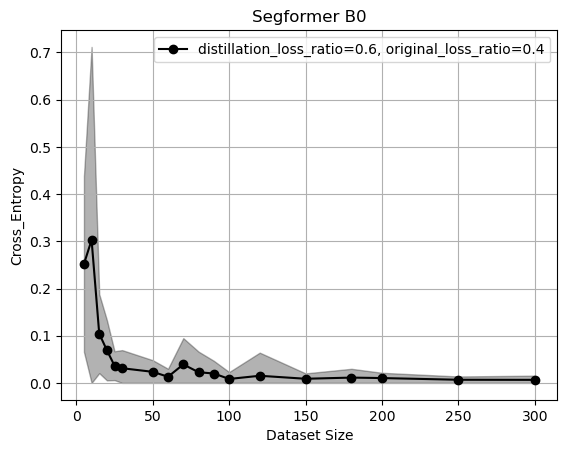

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0520')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0520_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0520_{int(teacher_ratio*100)}.png"))

plt.show()